In [1]:
from datasets import load_dataset, Dataset

from   lcdc import DatasetBuilder, LCDataset
from   lcdc.vars import Variability, TENTH_OF_SECOND, DataType as DT
import lcdc.preprocessing as pp
import lcdc.stats as stats
import lcdc.utils as utils

In [2]:
MMT_PATH = "/home/k/kyselica12/work/mmt/MMT"
IDX = 29517
classes = ["H-2A R/B"]
regexes = None
preprocessing = pp.Compose(
    pp.FilterByPeriodicity(Variability.PERIODIC),
    pp.SplitByRotationalPeriod(1), 
    pp.FilterFolded(100, 0.75), 
    pp.FilterMinLength(100),
)
statistics = [
    stats.MediumTime(), 
    stats.MediumPhase(), 
    stats.FourierSeries(8, fs=True, amplitude=True)
]

db = DatasetBuilder(MMT_PATH, norad_ids=[IDX], preprocessing=preprocessing, statistics=statistics, lazy=False)
ds = db.to_dict(data_types=[DT.MAG, DT.TIME, DT.PHASE, DT.DISTANCE])
# ds = ds.with_format("numpy", columns=["FourierCoefs"])

# preprocessing = pp.Compose(FilterByPeriodicity(Variability.PERIODIC), pp.FilterFolded(100, 0.75), pp.FilterMinLength(100))
# db = DatasetBuilder(MMT_PATH, classes=classes, regexes=regexes, preprocessing=preprocessing, lazy=False)

Loaded 1 objects and 391 tracks


Preparing data: 100%|██████████| 306/306 [00:00<00:00, 30768.75it/s]


In [3]:
ds["data"]

Dataset({
    features: ['mag', 'time', 'phase', 'distance', 'id', 'norad_id', 'label', 'period', 'timestamp', 'start_idx', 'end_idx', 'FourierAmplitude', 'FourierCoefs', 'MediumPhase', 'MediumTime'],
    num_rows: 4202
})

6246

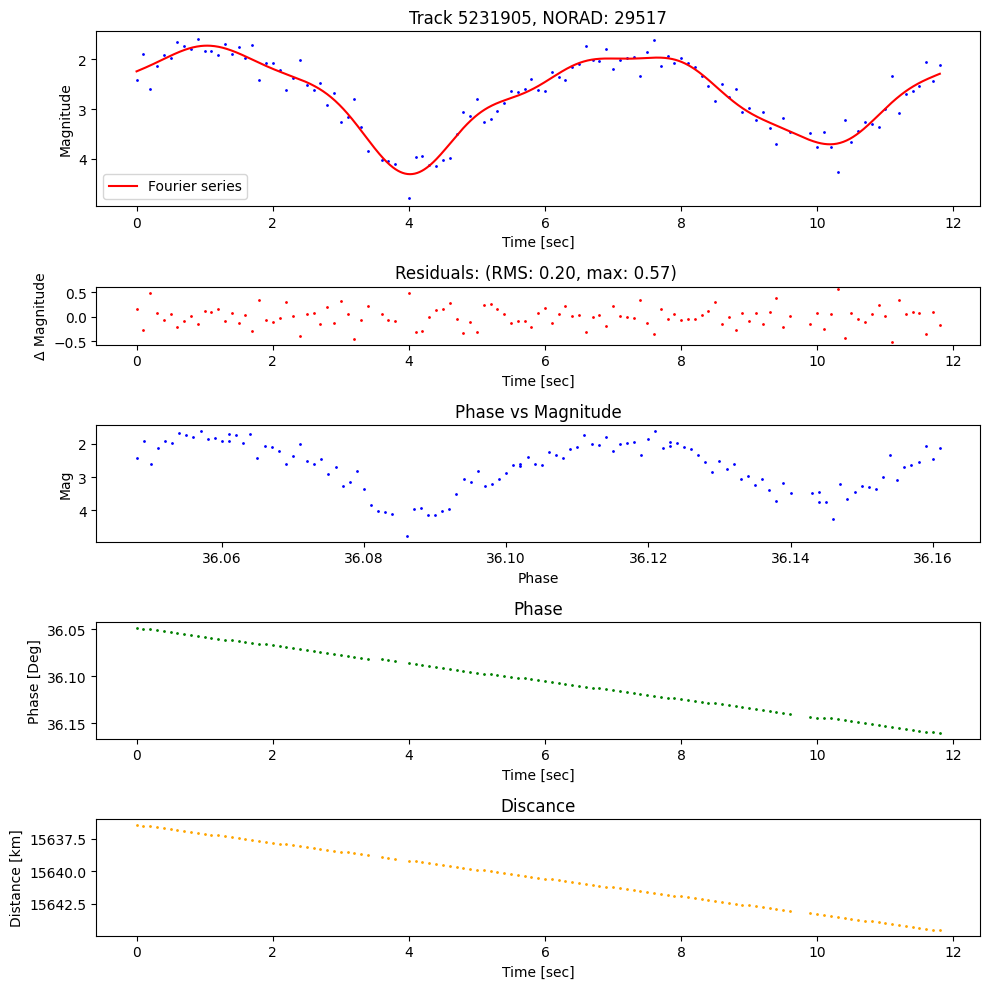

In [6]:
utils.plot_from_dict(ds["data"][301])
ds["data"]["start_idx"][301]

In [3]:
ds["data"] = ds["data"].with_format("numpy", columns=["FourierCoefs"])

In [4]:
ds["data"]["FourierCoefs"].shape

(4207, 17)

In [5]:
db.to_file(f"TEST",[])
# data_set.to_file(f"CZ-3B_{IDX}", [DataType.MAG, DataType.PHASE])

Preprocessing:   4%|▎         | 11/306 [00:00<00:02, 105.27it/s]

Preprocessing: 100%|██████████| 306/306 [00:04<00:00, 62.01it/s]


In [6]:
ds2 = LCDataset.dict_from_file("TEST")

In [7]:
ds2

{'data': Dataset({
     features: ['id', 'norad_id', 'label', 'period', 'timestamp', 'start_idx', 'end_idx', 'MediumPhase', 'MediumTime', 'FourierCoefs', 'FourierAmplitude'],
     num_rows: 306
 })}

In [6]:
data_dict = LCDataset.dict_from_file(f"CZ-3B_{IDX}")
ds2 = Dataset.from_dict(data_dict["data"])

In [4]:
ds["data"] = ds["data"].map(lambda x: {"a0": x["FourierCoefs"][0]}, remove_columns=["FourierCoefs"])

Map:   0%|          | 0/4202 [00:00<?, ? examples/s]

In [11]:
ds["data"] = ds["data"].with_format("numpy", columns=["a0", "MediumPhase", "MediumTime"])

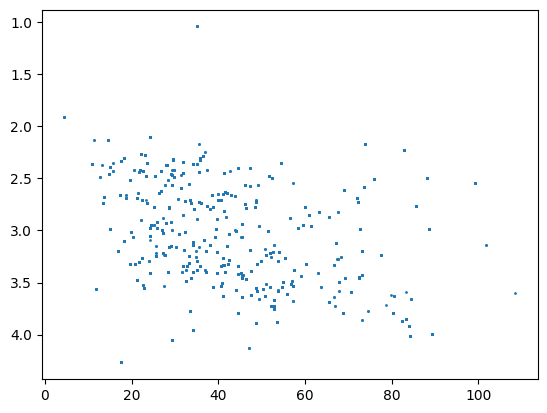

In [14]:
import matplotlib.pyplot as plt

# smaller points
plt.scatter(ds["data"]["MediumPhase"], ds["data"]["a0"], s=1)
plt.gca().invert_yaxis()

In [15]:
from   lcdc import DatasetBuilder
from   lcdc.vars import Variability, TENTH_OF_SECOND, DataType as DT
import lcdc.preprocessing as pp
import lcdc.stats as stats

MMT_PATH = "/home/k/kyselica12/work/mmt/MMT"
IDX = 29517
classes = ["H-2A R/B"]
regexes = None
preprocessing = pp.Compose(
    pp.FilterByPeriodicity(Variability.PERIODIC),
    pp.SplitByRotationalPeriod(1), 
    pp.SplitBySize(10_000*TENTH_OF_SECOND),
    pp.FilterFolded(100, 0.75), 
    pp.FilterMinLength(100),
    pp.ToGrid(10, size=10_000),
)

statistics = []

db = DatasetBuilder(MMT_PATH, norad_ids=[IDX], preprocessing=preprocessing, statistics=statistics, lazy=False)
ds = db.to_dict(data_types=[DT.MAG])
ds["data"] = ds["data"].with_format("numpy", columns=["mag"])

Loaded 1 objects and 391 tracks


Preparing data: 100%|██████████| 306/306 [00:00<00:00, 73936.12it/s]


In [32]:
db.to_file(f"TEST2",[DT.MAG])

Preprocessing: 100%|██████████| 306/306 [00:03<00:00, 80.14it/s] 


In [26]:
ds["data"].save_to_disk("TEST3")

Saving the dataset (0/1 shards):   0%|          | 0/4202 [00:00<?, ? examples/s]

In [6]:
ds["data"].to_parquet("TEST4")

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

336491958

In [19]:
xx = Dataset.from_parquet("TEST4")

In [20]:
xx = xx.with_format("numpy", columns=["mag"])
type(xx["mag"][0])

numpy.ndarray

In [27]:
%%timeit
xx2 = xx.filter(lambda x: np.sum(x["mag"] != 0) >= 100)

1.45 ms ± 20.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [23]:

statistics = []

db = DatasetBuilder(MMT_PATH, norad_ids=[IDX], lazy=False)
ds = db.to_dict(data_types=[DT.MAG])
xx1 = ds["data"].with_format("numpy", columns=["mag"])

Loaded 1 objects and 391 tracks


Preparing data: 100%|██████████| 391/391 [00:01<00:00, 311.01it/s]


In [26]:
%%timeit
db.preprocessing = pp.Compose(
    pp.FilterMinLength(100),
)
bin = []
for ts in db.tracks.values():
    t = ts[0]
    o = db.objects[t.norad_id]
    if (res := db.preprocessing(t, o)) != []:
        bin.append(res)
        

362 µs ± 5.53 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
